In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras import utils as np_utils

from random import shuffle
from tensorflow.python.client import device_lib

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For wider plots
plt.rcParams["figure.figsize"] = (20,6)

# Take my NVidia GPU into use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

In [2]:
files1 = glob.glob("./parkinsons/*Co*.txt")
files2 = glob.glob("./parkinsons/*Pt*.txt")
files=files1+files2
shuffle(files)

In [3]:
columns = ["elaps_time","L1", "L2","L3","L4","L5","L6","L7","L8","R1","R2","R3","R4","R5","R6","R7","R8","LTot","RTot"]

In [4]:
def getClassForHealthyOrNot(filename):
    if (filename.find("Co") >=0):
        return 0
    else:
        return 1


In [5]:
class Patient:
    def __init__(self,input_data,y):
        self.x = input_data
        self.y = y
        self.x_scaled = input_data

In [6]:
patients=[]
un_used_data=[]

for f in files:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+101,:]
        
        if data.shape[0] == 100:
            patients.append( Patient(data, ispark) )
        
        j=j+50

In [7]:
len(patients)

64793

In [8]:
shuffle(patients)

In [9]:
train = patients[:int(len(patients)*0.8)]
test = patients[int(len(patients)*0.8):]

In [10]:
train_concat=[]
for p in train:
    train_concat = train_concat+[p.x]

In [11]:
data_tr = pd.concat(train_concat,ignore_index=True)

In [12]:
scaler = StandardScaler()
scaler.fit_transform(data_tr)

array([[ 0.02479428,  0.49150893,  1.26798618, ..., -0.65160002,
         0.7574136 , -1.0927862 ],
       [-0.02470833,  0.37818128,  1.15904355, ..., -0.70883062,
         0.73620246, -1.10423666],
       [-0.05735898,  0.30178063,  1.02976496, ..., -0.70883062,
         0.7024822 , -1.10696297],
       ...,
       [-0.65033696, -0.63158076, -0.58258599, ..., -0.76394156,
         0.41531605, -1.129046  ],
       [-0.65033696, -0.63158076, -0.58258599, ..., -0.76394156,
         0.43870268, -1.129046  ],
       [-0.65033696, -0.67614781, -0.64649901, ..., -0.76394156,
         0.43081649, -1.129046  ]])

In [13]:
i=0
wo_time_col=["L1", "L2","L3","L4","L5","L6","L7","L8","R1","R2","R3","R4","R5","R6","R7","R8","LTot","RTot"]
for obj in train:
    obj.x_scaled = pd.DataFrame(scaler.transform(obj.x),columns=wo_time_col)
    i=i+1

In [14]:
for obj in test:
    obj.x_scaled = pd.DataFrame(scaler.transform(obj.x),columns=wo_time_col)
    i=i+1

In [15]:
X_scaled_list_train=[]
Y_list_train=[]

for obj in train:
    X_scaled_list_train = X_scaled_list_train + [obj.x_scaled]
    Y_list_train = Y_list_train + [obj.y]
    
X_scaled_arr_train = np.array(X_scaled_list_train)
Y_arr_train = np.array(Y_list_train)

In [16]:
X_scaled_arr_train.shape

(51834, 100, 18)

In [17]:
X_scaled_list_test=[]
Y_list_test=[]

for obj in test:
    X_scaled_list_test = X_scaled_list_test + [obj.x_scaled]
    Y_list_test = Y_list_test + [obj.y]
    
X_scaled_arr_test = np.array(X_scaled_list_test)
Y_arr_test = np.array(Y_list_test)

In [18]:
model = Sequential()
model.add((LSTM(100, dropout=0.5, 
                  return_sequences=True, 
                  input_shape=(X_scaled_arr_train.shape[1], X_scaled_arr_train.shape[2]))))

model.add(LSTM(100, dropout=0.5))
model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("./Model/Model/model_LSTM.v", 
                             monitor='val_accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False)


In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 100, 128)          42496     
_________________________________________________________________
lstm_7 (LSTM)                (None, 8)                 4384      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 46,889
Trainable params: 46,889
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_scaled_arr_train,Y_arr_train,epochs=10,validation_split=0.2,batch_size=34,shuffle=True,callbacks=[early_stopping, checkpoint])

Epoch 1/10
 581/1220 [=============>................] - ETA: 7s - loss: 0.5197 - accuracy: 0.7511 ETA

InternalError:    Failed to call ThenRnnBackward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 18, 100, 1, 100, 34, 100] 
	 [[{{node gradients/CudnnRNN_grad/CudnnRNNBackprop}}]]
	 [[PartitionedCall_1]] [Op:__inference_train_function_5802]

Function call stack:
train_function -> train_function -> train_function


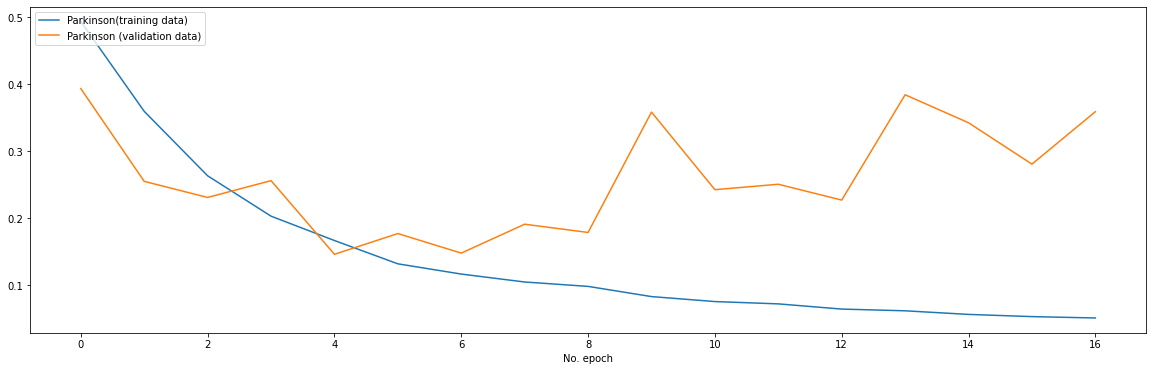

In [30]:
plt.plot(history.history['loss'], label='Parkinson(training data)')
plt.plot(history.history['val_loss'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

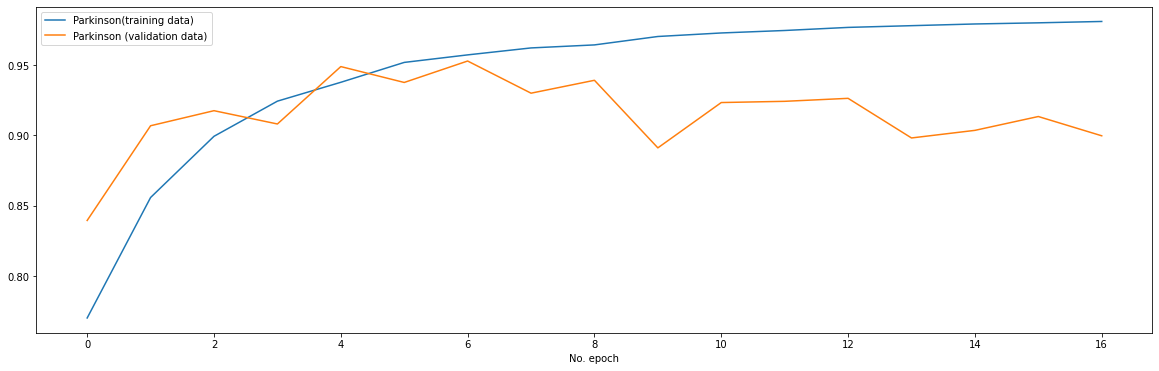

In [31]:
plt.plot(history.history['accuracy'], label='Parkinson(training data)')
plt.plot(history.history['val_accuracy'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [32]:
max(history.history['val_accuracy'])

0.9528310894966125

In [33]:
max(history.history['accuracy'])

0.9809486865997314

In [34]:
min(history.history['loss'])

0.05121348798274994

In [35]:
min(history.history['val_loss'])

0.1461927741765976